In [1]:
# proxy
import os
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import models
from torchvision import transforms, utils

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import json
from PIL import Image

In [4]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'
device = torch.device('cuda')

In [15]:
def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.axis('off')
    return image


preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def normalize(image):
    img = Variable(preprocess(image).unsqueeze(0).cuda())
    return img


def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

In [6]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.to(device)

In [7]:
labels = json.load(open('labels/imagenet_class_index.json'))

## Back Propagation

In [8]:
def visualize(image):
    img = normalize(image)
    img.requires_grad_()
    
    vgg.eval()
    out = vgg(img)
    
    vgg.zero_grad()
    acc, label = out.squeeze(0).max(0)
    label = label.reshape(1)
    
    out[0][label].backward()
    
    grad = img.grad.squeeze()
    grad.abs_()
    grad.clamp_(min=0)
    grad = grad.max(dim=0, keepdim=True)[0]
    grad = grad / grad.max()
    
    vmap = torchvision.utils.make_grid(grad.cpu()).numpy()
    vmap = np.transpose(vmap, (1,2,0))
    vmap = np.clip(vmap, 0, 1)

    inimg = normalize(image)
    inimg.squeeze_(0)
    inimg = inimg.cpu().numpy()
    inimg = np.transpose(inimg, (1,2,0))
    inimg = np.clip(inimg, 0, 1)

    plt.figure(figsize=(16,12))
    plt.subplot(1,2,1)
    plt.imshow(inimg)
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(vmap)
    plt.axis('off')
    
    return vmap

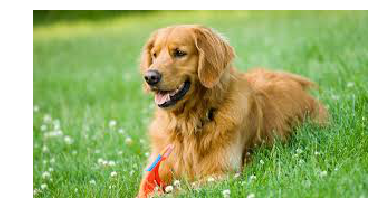

In [9]:
img = load_image('images/retr.jpg')

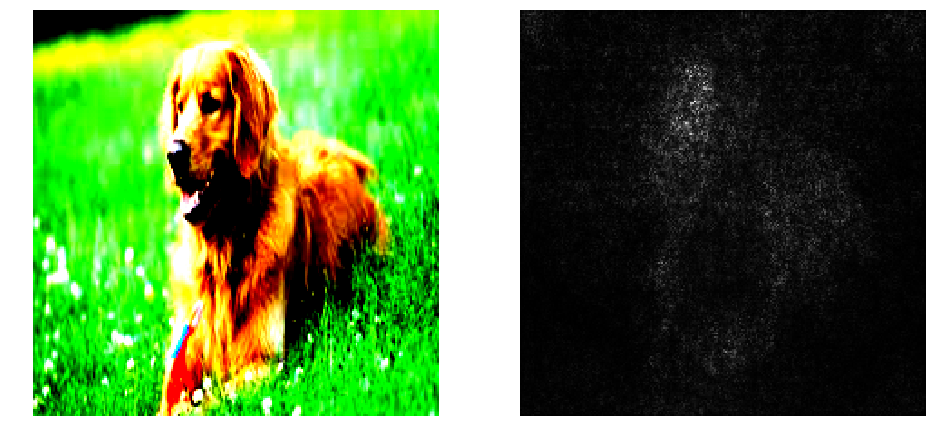

In [10]:
vis = visualize(img)

## SmoothGrad

In [17]:
def smoothgrad(image, label=207, x=20, percent_noise=20):
    tensor_input = torch.from_numpy(np.array(image)).type(torch.cuda.FloatTensor) # input is now of shape (w,h,c)
    final_grad = torch.zeros((1,3,224,224)).cuda()
    for i in range(x):
#         print('Sample:', i+1)
        temp_input = tensor_input
        # According to the paper, noise level corrresponds to stddev/(xmax-xmin). Hence stddev = noise_percentage * (max-min) /100
        noise = torch.from_numpy(np.random.normal(loc=0, scale=(percent_noise/100) * (tensor_input.max() - tensor_input.min()), size=temp_input.shape)).type(torch.cuda.FloatTensor)
        temp_input = (temp_input + noise).cpu().numpy()
        temp_input = Image.fromarray(temp_input.astype(np.uint8))
        temp_input = Variable(preprocess(temp_input).unsqueeze(0).cuda(), requires_grad=True)

        output = vgg.forward(temp_input)
        output[0][label].backward()
        final_grad += temp_input.grad.data
    
    grads = final_grad/x
    grads = grads.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.cpu().numpy(), axis=2)
    
    true_image = normalize(image)
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image.data)

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (16, 20)


    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads)
    plt.axis('off')  
    plt.title('SmoothGrad, Noise: ' + str(percent_noise) + '%, ' + 'Samples: ' + str(x))
    
    return grads

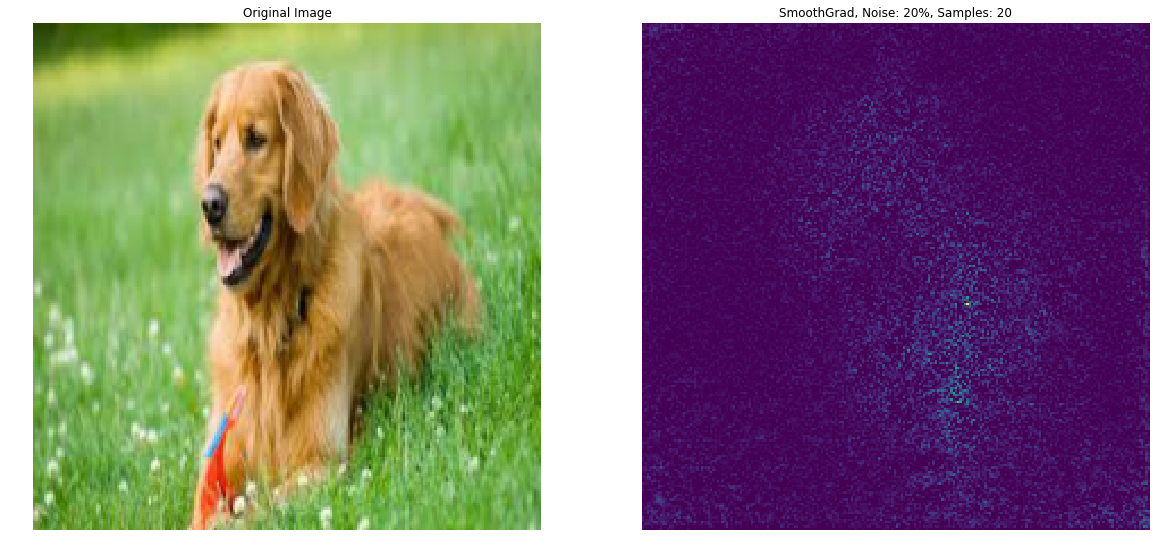

In [18]:
sg = smoothgrad(img)